In [730]:
%pylab inline
%config Inline.Backend.figure_format = 'retina'

from __future__ import division, print_function
import gwmemory

Populating the interactive namespace from numpy and matplotlib


In [731]:
!pip install lalsuite 

from pycbc import catalog
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.fft import fft

import numpy as np
import scipy as sp
import pylab
from scipy.fftpack import fft, rfft

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [732]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
from pycbc.filter.matchedfilter import match

<type 'dict'>
['__call__', '__class__', '__cmp__', '__delattr__', '__doc__', '__format__', '__func__', '__get__', '__getattribute__', '__hash__', '__init__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'im_class', 'im_func', 'im_self']
10001
10001


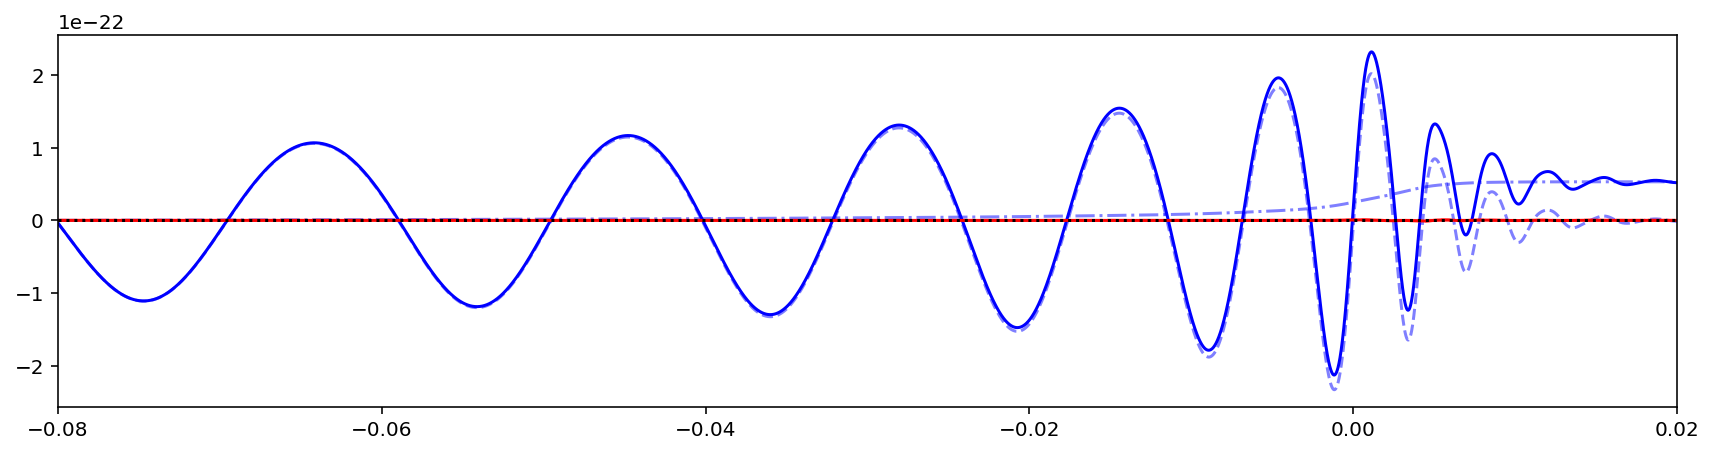

In [733]:
#In order to generate the memory we necessarily generate the time-domain oscillatory waveform
q = 1.
S1 = [0., 0., 0.]
S2 = [0., 0., 0.]

times = np.linspace(-0.08, 0.02, 10001)
#times = np.linspace(-0.98, .01, 10000)
surr = gwmemory.waveforms.Surrogate(q=q, S1=S1, S2=S2, MTot=60, distance=1500, times=times)



inc = np.pi / 2
pol = 0

oscillatory, times = surr.time_domain_oscillatory(inc=inc, pol=pol)
memory, times = surr.time_domain_memory(inc=inc, pol=pol)

fig = figure(figsize=(12, 6))
fig.add_subplot(2, 1, 1)
plot(times, oscillatory['plus'], linestyle='--', color='b', alpha=0.5)
plot(times, oscillatory['cross'], linestyle='--', color='r', alpha=0.5)
plot(times, memory['plus'], linestyle='-.', color='b', alpha=0.5)
plot(times, memory['cross'], linestyle='-.', color='r', alpha=0.5)
plot(times, oscillatory['plus'] + memory['plus'], color='b')
plot(times, oscillatory['cross'] + memory['cross'], color='r')
axhline(0, linestyle=':', color='k')
xlim(-0.08, 0.02)

print (type (oscillatory))

print (dir(surr.time_domain_oscillatory))

print (len(times))

print (times.size)


tight_layout()
show()
close()

In [734]:
from scipy import signal

In [735]:
mem_plus = memory['plus']

In [736]:
dt = times[1] - times[0]
window = signal.tukey(len(mem_plus))
win_mem= window*mem_plus
print (len(win_mem))
print(len(times))
freq_mem = np.fft.rfft(win_mem)*dt

10001
10001


In [737]:
dt = times[1] - times[0]
#print (help(np.fft.fftfreq))
fft_mem = np.fft.rfftfreq (len(win_mem),dt)
print (type(win_mem))                             
print (win_mem[0:10])
print (win_mem[50:60])
print (len(freq_mem))
print (len(fft_mem))

<type 'numpy.ndarray'>
[  0.00000000e+00   3.35408702e-34   2.01272404e-33   6.03906848e-33
   1.34222132e-32   2.51705746e-32   4.22932111e-32   6.57998198e-32
   9.67007336e-32   1.36006917e-31]
[  2.15395755e-29   2.28523473e-29   2.42175187e-29   2.56361238e-29
   2.71091968e-29   2.86377727e-29   3.02228868e-29   3.18655745e-29
   3.35668718e-29   3.53278146e-29]
5001
5001


In [738]:
osci_plus = oscillatory['plus']

In [739]:
window = signal.tukey(len(osci_plus))
win_osc= window*osci_plus
freq_osc = np.fft.rfft(win_osc)*dt

In [740]:
dt = times[1] - times[0]
fft_osc = np.fft.rfftfreq(len(win_osc), dt)
print (type(win_mem))                             
print (win_osc[0:10])
print (win_osc[50:60])
print (len(fft_osc))
print (len(freq_osc))

<type 'numpy.ndarray'>
[ -0.00000000e+00  -1.52076948e-30  -6.55402531e-30  -1.58065143e-29
  -2.99854012e-29  -4.97982491e-29  -7.59529985e-29  -1.09157948e-28
  -1.50121733e-28  -1.99553307e-28]
[ -1.82823365e-26  -1.93285252e-26  -2.04136556e-26  -2.15384289e-26
  -2.27035458e-26  -2.39097061e-26  -2.51576091e-26  -2.64479532e-26
  -2.77814360e-26  -2.91587543e-26]
5001
5001


In [741]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

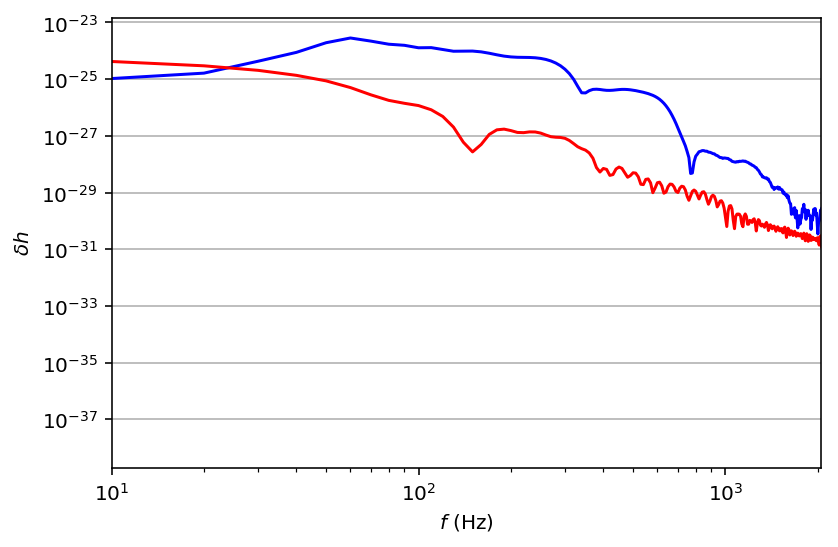

In [742]:
colours = ['r', 'b', 'g', 'k']

plt.figure()
plt.loglog(np.abs(fft_osc), np.abs(freq_osc) , linestyle='-', color='b', label = 'Osc fft')
plt.loglog(np.abs(fft_mem), np.abs(freq_mem), linestyle='-', color='r', label = 'Mem fft')


    

xlabel('$f$ (Hz)')
ylabel('$\delta h$')

xlim(10, 2048)
#ylim(1e-27, 1e-23)

ax = plt.gca()
ax.grid(True, axis='y')

tight_layout()
show()
close()

<class 'pycbc.types.timeseries.TimeSeries'>
0.0357142857143


Text(0.5,1,u'PSD')

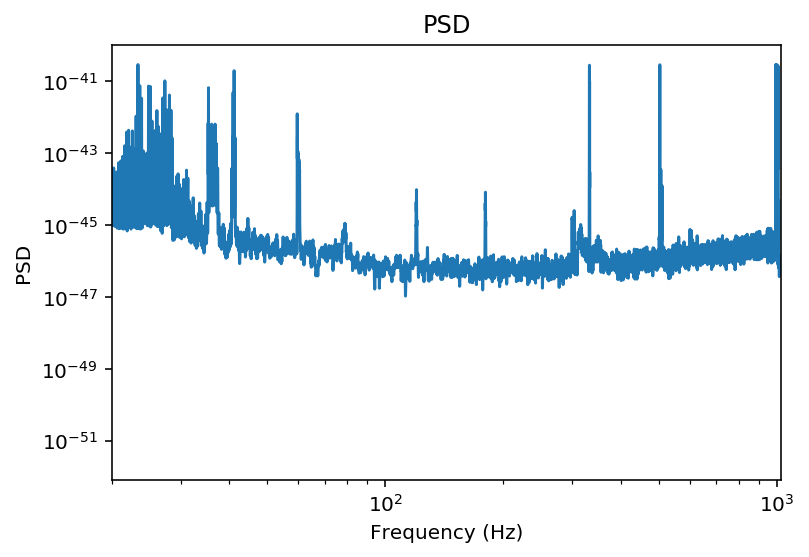

In [743]:
#Making psd 
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)
print (type (strain))

# Freq. bin size:
df = strain.delta_f
print (df)


# Sample rate:
samp_rate = 4096


# Upper and lower freq. limits
f_lower = 20.
f_upper = 1024


# Making PSD 
psd = strain.psd(4)
psd = interpolate(psd, df)
noise = inverse_spectrum_truncation(psd, 4 * samp_rate)

fs = noise.delta_f * np.arange(noise.data.size)

asd = sqrt(psd)

# Plotting noise curve
plt.loglog(fs, noise)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("PSD")   

Text(0.5,1,u'ASD')

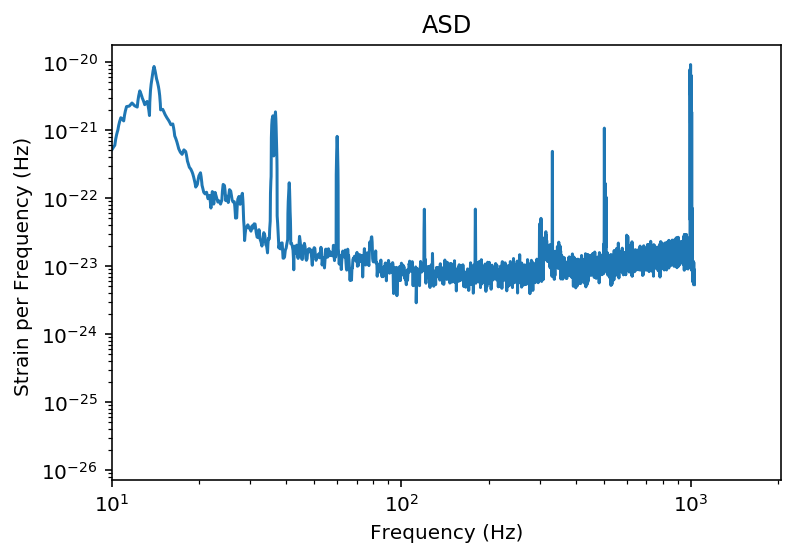

In [744]:
#ASD is what we want to graph
plt.loglog(fs,asd)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Strain per Frequency (Hz) ")
pylab.xlim(10, 2048)

plt.title("ASD")


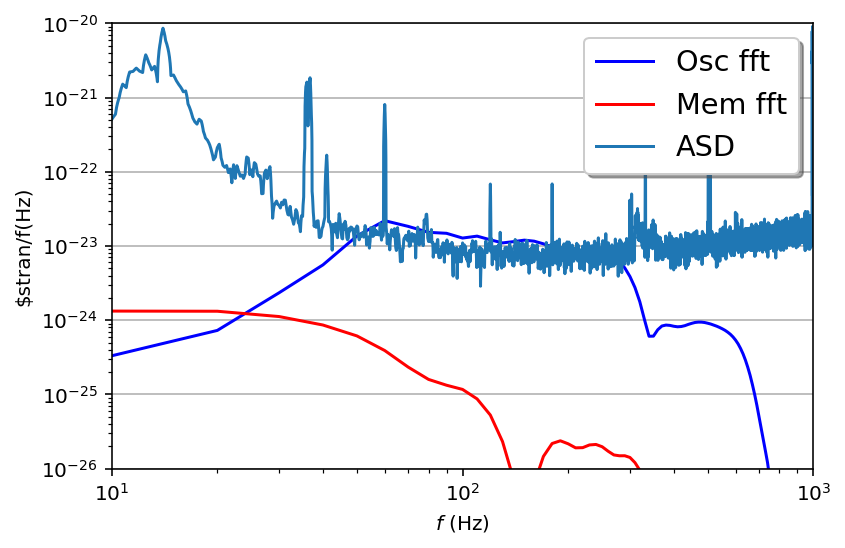

In [745]:
#Creating graph of the signal with the asd, memory, and oscillatory component combined
colours = ['r', 'b', 'g', 'k']

plt.figure()
plt.loglog(np.absolute(fft_osc),np.absolute(freq_osc*(sqrt(fft_osc))), linestyle='-', color='b', label='Osc fft')
plt.loglog(np.absolute(fft_mem),np.absolute(freq_mem*(sqrt(fft_osc))), linestyle='-', color='r', label='Mem fft')

#xlim(10, 2048)


               
#plotting asd
plt.loglog(fs,asd, label = 'ASD')
plt.legend(loc='upper right', shadow=True, fontsize='x-large')

#plot(asd, oscillatory['plus'] + memory['plus'], color='b')

    

xlabel('$f$ (Hz)')
ylabel('$stran/f(Hz)')

xlim(10, 1000)
ylim(1e-26, 1e-20)

ax = plt.gca()
ax.grid(True, axis='y')

#plt.title("60 Solar Masses and 50 Megparsecs")

tight_layout()
show()
close()

In [746]:
 #the noise weighted inner product
    # Function to calculate the noise weighted inner product of two vectors
# a and b (FFTs) with noise vector Sn (PSD); df = freq. bin size.a, b, and Sn must be same length
def InnerProduct(a, b, Sn, df):
    
    
    
    b_conj = np.conjugate(b)
    
    integrand = []
    
    for i in range(0,len(a)):
        intgrnd = a[i]*b_conj[i]/Sn[i]
        integrand.append(intgrnd)
            
    result_complex = 4*np.sum(integrand)*df
    
    result = np.real(result_complex)
    
    return result

In [747]:
 # Function to calculate the likelihood of data given parameters theta that
# generate strain h_theta (frequency series) with noise Sn (ASD); df = freq. bin size
#  h_theta, data, and Sn (ASD) must all be same length

def LogLikelihood(data, h_theta, Sn, df):
    
    h_minus_d = h_theta - data
    
    term = (-1.0/2)*InnerProduct(h_minus_d, h_minus_d, Sn, df)
    
    result = (term)

    return result

In [748]:
s = fft_osc + fft_mem

In [749]:
import numpy as np
from scipy import signal
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [750]:
#Interpolating to make  memory and oscillatory component (in freq domain)and asd equal. This will line them up
from scipy.interpolate import interp1d
#asd_freq = asd #(data)
sampfreq = 4096
datafreq = np.fft.fftfreq(fft_osc.size)*sampfreq
interpolate_asd = np.interp(datafreq, fs, asd)

In [751]:
print (len(s))
print (len(h_trial))
print (len(interpolate_asd ))

5001
5001
5001


In [752]:
#Template, adding in the lambda component. Will store log likelihood of the template
lambda_arr = np.arange(-10,10,.1)
like_arr = []
for weight in lambda_arr:
    h_trial = fft_osc + weight*fft_mem
    like_trial = LogLikelihood(s, h_trial, interpolate_asd, df)
    like_arr.append(like_trial)

In [753]:
#Normalizing the Likelihood array
likelihood1 = np.exp(asarray(like_arr))
Normal = likelihood1.sum()*.1
Norm = likelihood1/Normal
print (Normal)
print (Norm)


0.0
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  n

/home/pycbc/pycbc-software/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


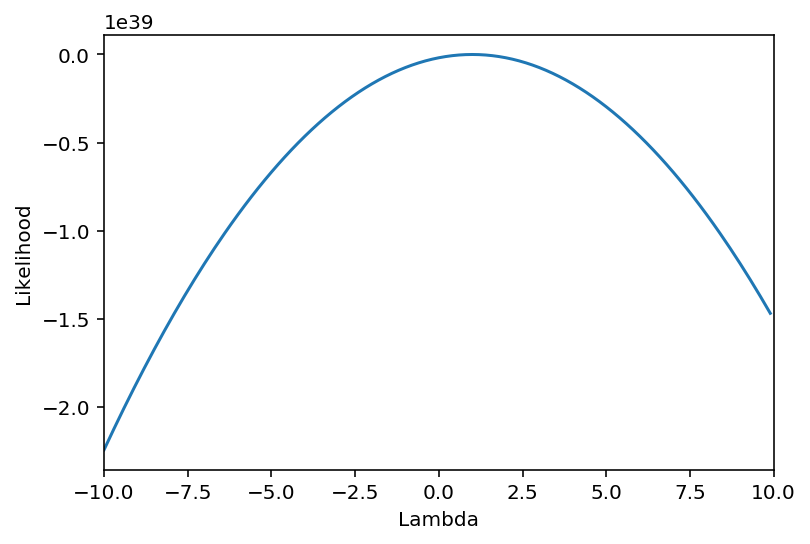

In [754]:
#Plotting the normalized likelihood array
import pylab
import numpy

x = lambda_arr 
y = np.asarray(like_arr)
#pylab.semilogy(x,y) 
pylab.plot(x,y)
pylab.xlim(-10, 10, 0.01)
pylab.xlabel('Lambda')
#pylab.ylim(-100, 0)
pylab.ylabel('Likelihood')
#plt.title("Likelihood for 60 solar massess and 5 megaparsecs", y=1.08)

 
pylab.show() 